### Import library and model

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU

### Import, scale and split Dataset

In [3]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('..\Dataset\EUR.csv')
 # GBP - VND
gbp = pd.read_csv("..\Dataset\GBP.csv")
 # JPY - VND
jpy = pd.read_csv("..\Dataset\JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

### MinMaxScaler

In [4]:
# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))

### Standardizate function

In [5]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

### Convert-data Function

In [6]:
# Convert train, test data into X_train, y_train, X_test, t_test

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

### Forecast function

In [7]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test):
    x_input = test[len(test)-100:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    #lst_output=[]
    n_steps=100
    i=0
    while(i<=90):
        if(len(temp_input)>100):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1)) #3D
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

### Visualize model

In [8]:
# Function to visualize the model
def visualize_RNN(model, train, test, pre_test, f3, f6, f9):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', end='6/1/2024', freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+100:],scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))
    plt.title('RNN Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

### Evaluate model

In [9]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE(%) =',mape)
    print('MAE =',mae)

### Function to implement SimpleRNN

In [10]:
def implement_RNN(train, test):
    time_step = 100
    # Convert Train, Test data
    X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

    # Define SimpleRNN model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    # Fit model
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

    # Predict Test data
    pre_test = model.predict(X_test)

    # Forecast next 30, 60, 90 days data
    forecast30, forecast60, forecast90 = forecast_days(model, test)

    # Visualize model
    visualize_RNN(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    evaluate(pre_test, test[100:])

# EUR - VND

In [11]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
 ## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
 ## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0707 - val_loss: 0.0032
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 5.5885e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 4.2803e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6954e-04 - val_loss: 4.0081e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5199e-04 - val_loss: 3.9995e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6131e-04 - val_loss: 3.7304e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2628e-04 - val_loss: 3.8701e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9426e-04 - val_loss: 4.2185e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2332e-04 - val_loss: 3.4816e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1898e-04 - val_loss: 3.4156e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1345e-04 - val_loss: 3.7657e-04

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8983e-04 - val_loss: 4.6175e-04
Epoch 66/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3399e-04 - val_loss: 2.7369e-04
Epoch 67/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4068e-04 - val_loss: 2.8155e-04
Epoch 68/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6851e-04 - val_loss: 2.7249e-04
Epoch 69/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7403e-04 - val_loss: 3.2169e-04
Epoch 70/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3370e-04 - val_loss: 2.7088e-04
Epoch 71/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1195e-04 - val_loss: 2.6821e-04
Epoch 72/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6724e-04 - val_loss: 2.6875e-04
Epoch 73/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8631e-04 - val_loss: 3.0907e-04
Epoch 74/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0442e-04 - val_loss: 5.9550e-04
Epoch 75/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6803e-

5 day output [[0.8791028]]
6 day input [0.71489286 0.69966354 0.69966354 0.69966354 0.72126793 0.72551797
 0.73685143 0.7467682  0.75491411 0.75491411 0.75491411 0.75615371
 0.74924739 0.75721622 0.76553922 0.74765362 0.74765362 0.74765362
 0.74995573 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638
 0.7251638  0.72374712 0.74039313 0.73614308 0.71506995 0.7180804
 0.7180804  0.7180804  0.71985125 0.71949708 0.74765362 0.78289357
 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021
 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107
 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.861

13 day output [[0.8936286]]
14 day input [0.75491411 0.75491411 0.75491411 0.75615371 0.74924739 0.75721622
 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573 0.73667434
 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638  0.72374712
 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804  0.7180804
 0.71985125 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846
 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116
 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698
 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989
 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0

23 day output [[0.9087311]]
24 day input [0.74995573 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638
 0.7251638  0.72374712 0.74039313 0.73614308 0.71506995 0.7180804
 0.7180804  0.7180804  0.71985125 0.71949708 0.74765362 0.78289357
 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021
 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107
 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.86803406 0.87247336
 0.87364662 0.87676102 0.87797952 0.87910283 0.87984633 0.88221228
 0.88514203 0.88715202 0.8

31 day output [[0.9190848]]
32 day input [0.74039313 0.73614308 0.71506995 0.7180804  0.7180804  0.7180804
 0.71985125 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846
 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116
 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698
 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989
 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.86803406 0.87247336 0.87364662 0.87676102
 0.87797952 0.87910283 0.87984633 0.88221228 0.88514203 0.88715202
 0.88874567 0.8894822  0.89148235 0.8936286  0.895621   0.89704937
 0.89827359 0.90013379 0

41 day output [[0.929634]]
42 day input [0.77226846 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021
 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107
 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.86803406 0.87247336
 0.87364662 0.87676102 0.87797952 0.87910283 0.87984633 0.88221228
 0.88514203 0.88715202 0.88874567 0.8894822  0.89148235 0.8936286
 0.895621   0.89704937 0.89827359 0.90013379 0.90161741 0.9034512
 0.90489662 0.90643209 0.90757078 0.9087311  0.91024131 0.91177934
 0.91318077 0.91413951 0.91

51 day output [[0.9384273]]
52 day input [0.73543474 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312
 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042
 0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.86803406 0.87247336 0.87364662 0.87676102 0.87797952 0.87910283
 0.87984633 0.88221228 0.88514203 0.88715202 0.88874567 0.8894822
 0.89148235 0.8936286  0.895621   0.89704937 0.89827359 0.90013379
 0.90161741 0.9034512  0.90489662 0.90643209 0.90757078 0.9087311
 0.91024131 0.91177934 0.91318077 0.91413951 0.91532791 0.91666824
 0.9180432  0.91908479 0.91996598 0.9211114  0.92241603 0.92371142
 0.92466116 0.92555737 0

61 day output [[0.9455768]]
62 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.86803406 0.87247336 0.87364662 0.87676102
 0.87797952 0.87910283 0.87984633 0.88221228 0.88514203 0.88715202
 0.88874567 0.8894822  0.89148235 0.8936286  0.895621   0.89704937
 0.89827359 0.90013379 0.90161741 0.9034512  0.90489662 0.90643209
 0.90757078 0.9087311  0.91024131 0.91177934 0.91318077 0.91413951
 0.91532791 0.91666824 0.9180432  0.91908479 0.91996598 0.9211114
 0.92241603 0.92371142 0.92466116 0.92555737 0.92652214 0.92763507
 0.92870021 0.92963398 0.93052024 0.9314335  0.93242002 0.93336123
 0.9342255  0.93503708 0

71 day output [[0.9512498]]
72 day input [0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.86803406 0.87247336
 0.87364662 0.87676102 0.87797952 0.87910283 0.87984633 0.88221228
 0.88514203 0.88715202 0.88874567 0.8894822  0.89148235 0.8936286
 0.895621   0.89704937 0.89827359 0.90013379 0.90161741 0.9034512
 0.90489662 0.90643209 0.90757078 0.9087311  0.91024131 0.91177934
 0.91318077 0.91413951 0.91532791 0.91666824 0.9180432  0.91908479
 0.91996598 0.9211114  0.92241603 0.92371142 0.92466116 0.92555737
 0.92652214 0.92763507 0.92870021 0.92963398 0.93052024 0.9314335
 0.93242002 0.93336123 0.9342255  0.93503708 0.93587524 0.93675846
 0.93761998 0.93842733 0.93916637 0.93991464 0.9406864  0.9414717
 0.94220614 0.94288117 0.94

81 day output [[0.9557161]]
82 day input [0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.86803406 0.87247336 0.87364662 0.87676102 0.87797952 0.87910283
 0.87984633 0.88221228 0.88514203 0.88715202 0.88874567 0.8894822
 0.89148235 0.8936286  0.895621   0.89704937 0.89827359 0.90013379
 0.90161741 0.9034512  0.90489662 0.90643209 0.90757078 0.9087311
 0.91024131 0.91177934 0.91318077 0.91413951 0.91532791 0.91666824
 0.9180432  0.91908479 0.91996598 0.9211114  0.92241603 0.92371142
 0.92466116 0.92555737 0.92652214 0.92763507 0.92870021 0.92963398
 0.93052024 0.9314335  0.93242002 0.93336123 0.9342255  0.93503708
 0.93587524 0.93675846 0.93761998 0.93842733 0.93916637 0.93991464
 0.9406864  0.9414717  0.94220614 0.94288117 0.94353843 0.94421691
 0.94491202 0.94557679 0.94619185 0.94678169 0.9473784  0.94798464
 0.94856638 0.94911397 

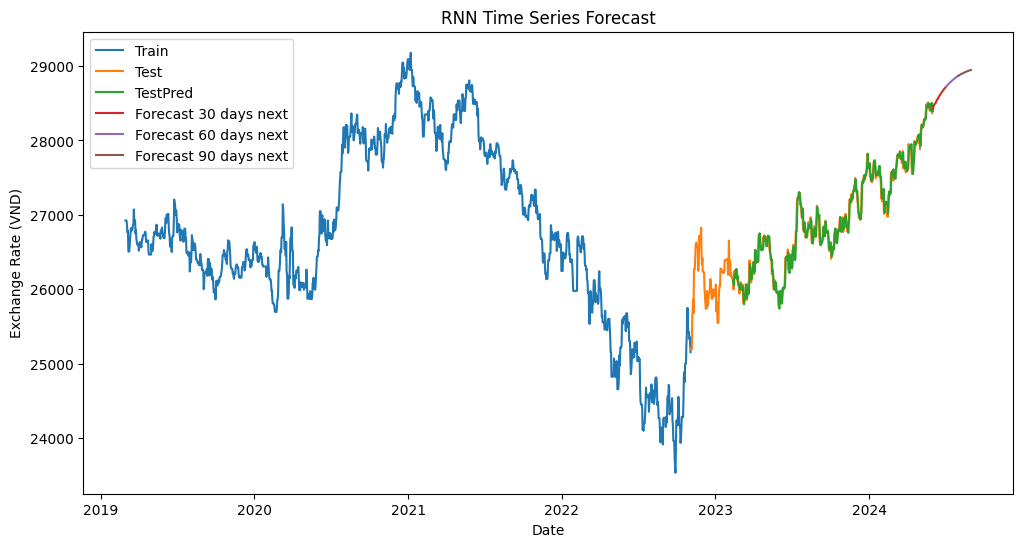

RMSE = 90.21203879013466
MAPE(%) = 0.2394041266192693
MAE = 64.43039325105057


In [12]:
a =implement_RNN(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1120 - val_loss: 0.0025
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 7.6166e-04
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 5.3921e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 5.4934e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 5.2999e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7599e-04 - val_loss: 5.0744e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2522e-04 - val_loss: 4.9613e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7416e-04 - val_loss: 4.7985e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7193e-04 - val_loss: 5.5614e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6293e-04 - val_loss: 4.6010e-04
Epoch 12/100
23/23

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0927e-04 - val_loss: 2.8670e-04
Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8822e-04 - val_loss: 2.9959e-04
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5790e-04 - val_loss: 4.1109e-04
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2380e-04 - val_loss: 2.9705e-04
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4786e-04 - val_loss: 2.6762e-04
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5020e-04 - val_loss: 2.6252e-04
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4442e-04 - val_loss: 3.2582e-04
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7612e-04 - val_loss: 4.3272e-04
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8210e-04 - val_loss: 2.7941e-04
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0599e-04 - val_loss: 2.6434e-04
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5842e-04 - 

4 day output [[0.8600474]]
5 day input [0.69559058 0.71489286 0.69966354 0.69966354 0.69966354 0.72126793
 0.72551797 0.73685143 0.7467682  0.75491411 0.75491411 0.75491411
 0.75615371 0.74924739 0.75721622 0.76553922 0.74765362 0.74765362
 0.74765362 0.74995573 0.73667434 0.74499734 0.76571631 0.7251638
 0.7251638  0.7251638  0.72374712 0.74039313 0.73614308 0.71506995
 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708 0.74765362
 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021
 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474
 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312
 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042
 0.8029042  0.78448734 0.79440411 0.77032052 0.79652913 0.81565433
 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.

14 day output [[0.8530701]]
15 day input [0.75491411 0.75491411 0.75615371 0.74924739 0.75721622 0.76553922
 0.74765362 0.74765362 0.74765362 0.74995573 0.73667434 0.74499734
 0.76571631 0.7251638  0.7251638  0.7251638  0.72374712 0.74039313
 0.73614308 0.71506995 0.7180804  0.7180804  0.7180804  0.71985125
 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846
 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116
 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312
 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707
 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.8656726

24 day output [[0.8463769]]
25 day input [0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86567265 0.86454439 0.86317939
 0.86362088 0.8600474  0.86134267 0.85878938 0.85880238 0.85765958
 0.85687459 0.8557657  0.

34 day output [[0.8394977]]
35 day input [0.7180804  0.7180804  0.7180804  0.71985125 0.71949708 0.74765362
 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021
 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474
 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312
 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042
 0.8029042  0.78448734 0.79440411 0.77032052 0.79652913 0.81565433
 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86567265
 0.86454439 0.86317939 0.86362088 0.8600474  0.86134267 0.85878938
 0.85880238 0.85765958 0.85687459 0.8557657  0.85709119 0.8546744
 0.85389203 0.85307008 0.85229552 0.85187    0.85123146 0.85045624
 0.85012293 0.84910399 

44 day output [[0.8339534]]
45 day input [0.76536214 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116
 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312
 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707
 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.86567265 0.86454439 0.86317939 0.86362088 0.8600474
 0.86134267 0.85878938 0.85880238 0.85765958 0.85687459 0.8557657
 0.85709119 0.8546744  0.85389203 0.85307008 0.85229552 0.85187
 0.85123146 0.85045624 0.85012293 0.84910399 0.84837216 0.84769249
 0.84667158 0.8463769  0.84662217 0.84499955 0.84409511 0.84380853
 0.84285152 0.84194171 0.8

54 day output [[0.8287209]]
55 day input [0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86567265 0.86454439 0.86317939
 0.86362088 0.8600474  0.86134267 0.85878938 0.85880238 0.85765958
 0.85687459 0.8557657  0.85709119 0.8546744  0.85389203 0.85307008
 0.85229552 0.85187    0.85123146 0.85045624 0.85012293 0.84910399
 0.84837216 0.84769249 0.84667158 0.8463769  0.84662217 0.84499955
 0.84409511 0.84380853 0.84285152 0.84194171 0.84158367 0.84099776
 0.84044307 0.83949769 0.83858997 0.83840305 0.83827353 0.83725864
 0.83658743 0.83611006 

62 day output [[0.82484084]]
63 day input [0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.86567265 0.86454439 0.86317939 0.86362088 0.8600474
 0.86134267 0.85878938 0.85880238 0.85765958 0.85687459 0.8557657
 0.85709119 0.8546744  0.85389203 0.85307008 0.85229552 0.85187
 0.85123146 0.85045624 0.85012293 0.84910399 0.84837216 0.84769249
 0.84667158 0.8463769  0.84662217 0.84499955 0.84409511 0.84380853
 0.84285152 0.84194171 0.84158367 0.84099776 0.84044307 0.83949769
 0.83858997 0.83840305 0.83827353 0.83725864 0.83658743 0.83611006
 0.83570117 0.83508313 0.83448595 0.83395338 0.83346993 0.83267391
 0.83210957 0.83172953 0.

72 day output [[0.8203691]]
73 day input [0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86567265 0.86454439 0.86317939
 0.86362088 0.8600474  0.86134267 0.85878938 0.85880238 0.85765958
 0.85687459 0.8557657  0.85709119 0.8546744  0.85389203 0.85307008
 0.85229552 0.85187    0.85123146 0.85045624 0.85012293 0.84910399
 0.84837216 0.84769249 0.84667158 0.8463769  0.84662217 0.84499955
 0.84409511 0.84380853 0.84285152 0.84194171 0.84158367 0.84099776
 0.84044307 0.83949769 0.83858997 0.83840305 0.83827353 0.83725864
 0.83658743 0.83611006 0.83570117 0.83508313 0.83448595 0.83395338
 0.83346993 0.83267391 0.83210957 0.83172953 0.83127373 0.83064079
 0.83013201 0.82960469 0.82922798 0.82872093 0.82821178 0.82772201
 0.82729179 0.82670903 

82 day output [[0.8161446]]
83 day input [0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86567265
 0.86454439 0.86317939 0.86362088 0.8600474  0.86134267 0.85878938
 0.85880238 0.85765958 0.85687459 0.8557657  0.85709119 0.8546744
 0.85389203 0.85307008 0.85229552 0.85187    0.85123146 0.85045624
 0.85012293 0.84910399 0.84837216 0.84769249 0.84667158 0.8463769
 0.84662217 0.84499955 0.84409511 0.84380853 0.84285152 0.84194171
 0.84158367 0.84099776 0.84044307 0.83949769 0.83858997 0.83840305
 0.83827353 0.83725864 0.83658743 0.83611006 0.83570117 0.83508313
 0.83448595 0.83395338 0.83346993 0.83267391 0.83210957 0.83172953
 0.83127373 0.83064079 0.83013201 0.82960469 0.82922798 0.82872093
 0.82821178 0.82772201 0.82729179 0.82670903 0.8262378  0.82580298
 0.82535022 0.82484084 0.82439667 0.82389617 0.82346952 0.82297969
 0.82254457 0.82212913 

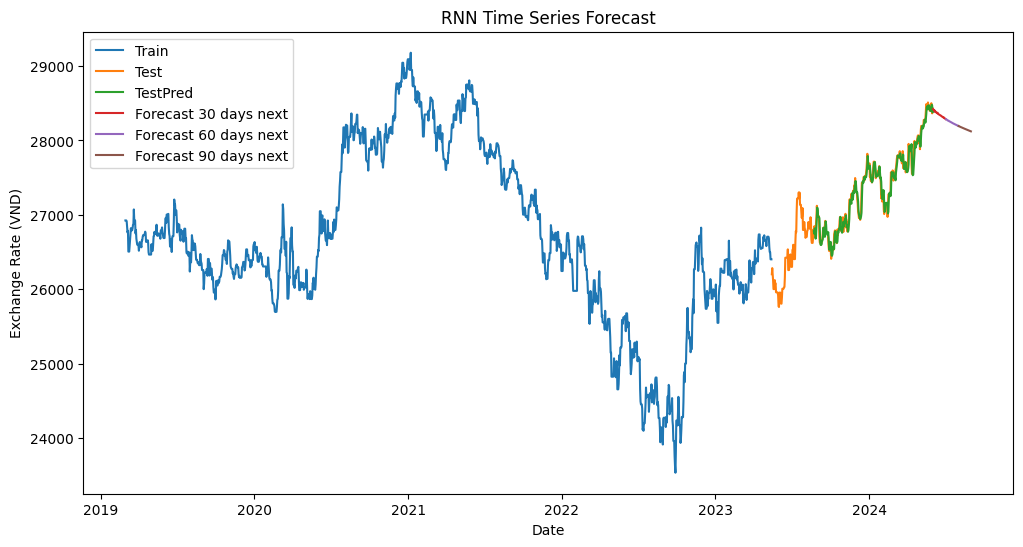

RMSE = 87.36691925632122
MAPE(%) = 0.23329087725935108
MAE = 63.76445587588039


In [13]:
implement_RNN(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3713 - val_loss: 0.0247
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - val_loss: 0.0047
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 7.5455e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 7.4580e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 7.1454e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 7.9670e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 6.7815e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 7.9757e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 7.2994e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 6.3884e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s

Epoch 66/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1557e-04 - val_loss: 3.3845e-04
Epoch 67/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9633e-04 - val_loss: 4.0560e-04
Epoch 68/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8059e-04 - val_loss: 2.8970e-04
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5633e-04 - val_loss: 2.6164e-04
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3173e-04 - val_loss: 2.6616e-04
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5696e-04 - val_loss: 3.0007e-04
Epoch 72/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3685e-04 - val_loss: 3.2393e-04
Epoch 73/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3803e-04 - val_loss: 2.9059e-04
Epoch 74/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3778e-04 - val_loss: 3.5599e-04
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3649e-04 - val_loss: 2.7158e-04
Epoch 76/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

4 day output [[0.8325187]]
5 day input [0.69559058 0.71489286 0.69966354 0.69966354 0.69966354 0.72126793
 0.72551797 0.73685143 0.7467682  0.75491411 0.75491411 0.75491411
 0.75615371 0.74924739 0.75721622 0.76553922 0.74765362 0.74765362
 0.74765362 0.74995573 0.73667434 0.74499734 0.76571631 0.7251638
 0.7251638  0.7251638  0.72374712 0.74039313 0.73614308 0.71506995
 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708 0.74765362
 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021
 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474
 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312
 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042
 0.8029042  0.78448734 0.79440411 0.77032052 0.79652913 0.81565433
 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.

12 day output [[0.7910939]]
13 day input [0.7467682  0.75491411 0.75491411 0.75491411 0.75615371 0.74924739
 0.75721622 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573
 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.

22 day output [[0.74769795]]
23 day input [0.74765362 0.74995573 0.73667434 0.74499734 0.76571631 0.7251638
 0.7251638  0.7251638  0.72374712 0.74039313 0.73614308 0.71506995
 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708 0.74765362
 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021
 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474
 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312
 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042
 0.8029042  0.78448734 0.79440411 0.77032052 0.79652913 0.81565433
 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.85631102
 0.85214972 0.84584177 0.83879626 0.8325187  0.82713324 0.82119608
 0.81612188 0.81117761

31 day output [[0.71245974]]
32 day input [0.74039313 0.73614308 0.71506995 0.7180804  0.7180804  0.7180804
 0.71985125 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846
 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116
 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698
 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989
 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.85631102 0.85214972 0.84584177 0.83879626
 0.8325187  0.82713324 0.82119608 0.81612188 0.81117761 0.80567205
 0.80028623 0.79584122 0.79109389 0.78635514 0.78209835 0.77810407
 0.77364904 0.76860946 

41 day output [[0.6755605]]
42 day input [0.77226846 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021
 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107
 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.85631102 0.85214972
 0.84584177 0.83879626 0.8325187  0.82713324 0.82119608 0.81612188
 0.81117761 0.80567205 0.80028623 0.79584122 0.79109389 0.78635514
 0.78209835 0.77810407 0.77364904 0.76860946 0.76477414 0.76038432
 0.75612754 0.75195056 0.74769795 0.74323219 0.73921156 0.73535681
 0.73138148 0.72762811 0

49 day output [[0.64676327]]
50 day input [0.71135116 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698
 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989
 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.85631102 0.85214972 0.84584177 0.83879626
 0.8325187  0.82713324 0.82119608 0.81612188 0.81117761 0.80567205
 0.80028623 0.79584122 0.79109389 0.78635514 0.78209835 0.77810407
 0.77364904 0.76860946 0.76477414 0.76038432 0.75612754 0.75195056
 0.74769795 0.74323219 0.73921156 0.73535681 0.73138148 0.72762811
 0.72371465 0.71988726 0.71617889 0.71245974 0.708758   0.70502734
 0.70127565 0.69751954

59 day output [[0.6110319]]
60 day input [0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.85631102 0.85214972
 0.84584177 0.83879626 0.8325187  0.82713324 0.82119608 0.81612188
 0.81117761 0.80567205 0.80028623 0.79584122 0.79109389 0.78635514
 0.78209835 0.77810407 0.77364904 0.76860946 0.76477414 0.76038432
 0.75612754 0.75195056 0.74769795 0.74323219 0.73921156 0.73535681
 0.73138148 0.72762811 0.72371465 0.71988726 0.71617889 0.71245974
 0.708758   0.70502734 0.70127565 0.69751954 0.69383293 0.69021529
 0.68651795 0.68283784 0.6792205  0.67556047 0.67195994 0.66835052
 0.66472864 0.66113031 0

67 day output [[0.582311]]
68 day input [0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.85631102 0.85214972 0.84584177 0.83879626
 0.8325187  0.82713324 0.82119608 0.81612188 0.81117761 0.80567205
 0.80028623 0.79584122 0.79109389 0.78635514 0.78209835 0.77810407
 0.77364904 0.76860946 0.76477414 0.76038432 0.75612754 0.75195056
 0.74769795 0.74323219 0.73921156 0.73535681 0.73138148 0.72762811
 0.72371465 0.71988726 0.71617889 0.71245974 0.708758   0.70502734
 0.70127565 0.69751954 0.69383293 0.69021529 0.68651795 0.68283784
 0.6792205  0.67556047 0.67195994 0.66835052 0.66472864 0.66113031
 0.65750432 0.65393686 0.65034944 0.64676327 0.64318138 0.63961703
 0.63603163 0.63247144 0

77 day output [[0.5460437]]
78 day input [0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.85631102 0.85214972
 0.84584177 0.83879626 0.8325187  0.82713324 0.82119608 0.81612188
 0.81117761 0.80567205 0.80028623 0.79584122 0.79109389 0.78635514
 0.78209835 0.77810407 0.77364904 0.76860946 0.76477414 0.76038432
 0.75612754 0.75195056 0.74769795 0.74323219 0.73921156 0.73535681
 0.73138148 0.72762811 0.72371465 0.71988726 0.71617889 0.71245974
 0.708758   0.70502734 0.70127565 0.69751954 0.69383293 0.69021529
 0.68651795 0.68283784 0.6792205  0.67556047 0.67195994 0.66835052
 0.66472864 0.66113031 0.65750432 0.65393686 0.65034944 0.64676327
 0.64318138 0.63961703 0.63603163 0.63247144 0.62890512 0.62532675
 0.62175399 0.61818331 0.61460447 0.61103189 0.60745335 0.60387069
 0.60028499 0.5967005

86 day output [[0.5130758]]
87 day input [0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.85631102 0.85214972 0.84584177 0.83879626 0.8325187
 0.82713324 0.82119608 0.81612188 0.81117761 0.80567205 0.80028623
 0.79584122 0.79109389 0.78635514 0.78209835 0.77810407 0.77364904
 0.76860946 0.76477414 0.76038432 0.75612754 0.75195056 0.74769795
 0.74323219 0.73921156 0.73535681 0.73138148 0.72762811 0.72371465
 0.71988726 0.71617889 0.71245974 0.708758   0.70502734 0.70127565
 0.69751954 0.69383293 0.69021529 0.68651795 0.68283784 0.6792205
 0.67556047 0.67195994 0.66835052 0.66472864 0.66113031 0.65750432
 0.65393686 0.65034944 0.64676327 0.64318138 0.63961703 0.63603163
 0.63247144 0.62890512 0.62532675 0.62175399 0.61818331 0.61460447
 0.61103189 0.60745335 0.60387069 0.60028499 0.59670055 0.59310943
 0.58951414 0.58591735 0.58231097 0.57870167 0.57509327 0.57147378
 0.56785834 0.5642308  

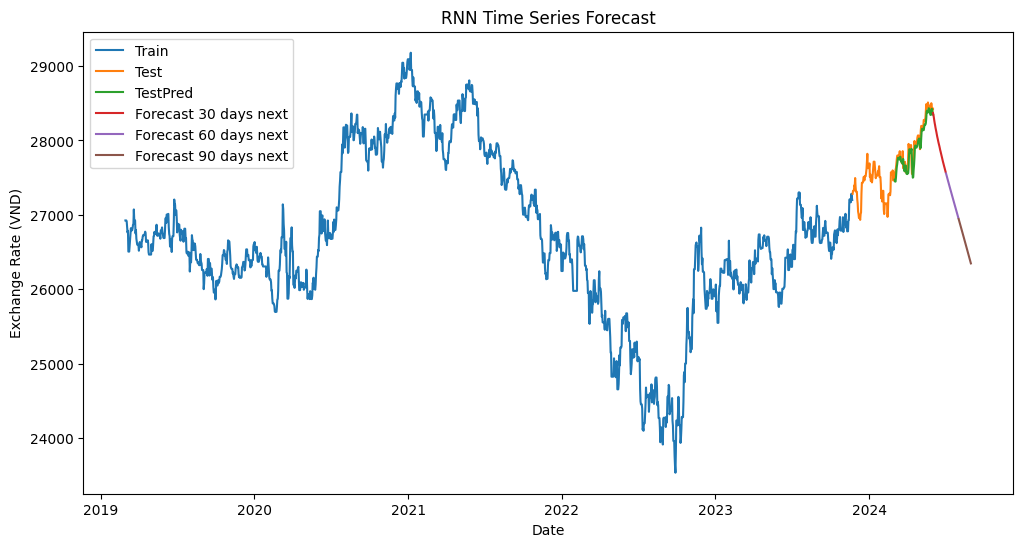

RMSE = 100.86323976380743
MAPE(%) = 0.2836331232742148
MAE = 79.35321841032597


In [14]:
implement_RNN(train_eur_3_sc, test_eur_3_sc)

# GBP - VND



In [15]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
 ## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
 ## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0461 - val_loss: 0.0034
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 4.7125e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 4.6478e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 5.1441e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5824e-04 - val_loss: 4.3388e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6803e-04 - val_loss: 4.4794e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0938e-04 - val_loss: 5.3493e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3410e-04 - val_loss: 4.7821e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1973e-04 - val_loss: 5.0637e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2453e-04 - val_loss: 3.9614e-04
Epoch 12/

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2214e-04 - val_loss: 5.5754e-04
Epoch 66/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9004e-04 - val_loss: 5.6017e-04
Epoch 67/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4523e-04 - val_loss: 2.6791e-04
Epoch 68/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6163e-04 - val_loss: 3.6358e-04
Epoch 69/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2346e-04 - val_loss: 2.8446e-04
Epoch 70/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1256e-04 - val_loss: 2.7725e-04
Epoch 71/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6956e-04 - val_loss: 3.3817e-04
Epoch 72/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8791e-04 - val_loss: 3.0736e-04
Epoch 73/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6006e-04 - val_loss: 2.6397e-04
Epoch 74/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3909e-04 - val_loss: 4.1376e-04
Epoch 75/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4

4 day output [[0.9305815]]
5 day input [0.8030303  0.81572482 0.8030303  0.8030303  0.8030303  0.82391482
 0.82760033 0.84657385 0.84862135 0.86936937 0.86936937 0.86936937
 0.87401037 0.85681136 0.86527437 0.87278187 0.85544636 0.85544636
 0.85544636 0.85517336 0.84220584 0.85394485 0.87728638 0.81381381
 0.81381381 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782
 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 

14 day output [[0.87015486]]
15 day input [0.86936937 0.86936937 0.87401037 0.85681136 0.86527437 0.87278187
 0.85544636 0.85544636 0.85544636 0.85517336 0.84220584 0.85394485
 0.87728638 0.81381381 0.81381381 0.81381381 0.81599782 0.83292383
 0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.9608237

24 day output [[0.8179243]]
25 day input [0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.96082377 0.95600086 0.94627899
 0.93762112 0.93058151 0.92372251 0.91716313 0.90980965 0.90472478
 0.89849627 0.8922928

34 day output [[0.77089095]]
35 day input [0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96082377
 0.95600086 0.94627899 0.93762112 0.93058151 0.92372251 0.91716313
 0.90980965 0.90472478 0.89849627 0.8922928  0.88697326 0.88117766
 0.87567347 0.87015486 0.86430162 0.85850328 0.85293531 0.84783155
 0.84279132 0.837606

44 day output [[0.7247219]]
45 day input [0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96082377 0.95600086 0.94627899 0.93762112 0.93058151
 0.92372251 0.91716313 0.90980965 0.90472478 0.89849627 0.8922928
 0.88697326 0.88117766 0.87567347 0.87015486 0.86430162 0.85850328
 0.85293531 0.84783155 0.84279132 0.83760607 0.83214992 0.82748449
 0.82264388 0.81792432 0.81328619 0.80872142 0.80392969 0.79920721
 0.79443628 0.78976607 

54 day output [[0.67945737]]
55 day input [0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.96082377 0.95600086 0.94627899
 0.93762112 0.93058151 0.92372251 0.91716313 0.90980965 0.90472478
 0.89849627 0.8922928  0.88697326 0.88117766 0.87567347 0.87015486
 0.86430162 0.85850328 0.85293531 0.84783155 0.84279132 0.83760607
 0.83214992 0.82748449 0.82264388 0.81792432 0.81328619 0.80872142
 0.80392969 0.79920721 0.79443628 0.78976607 0.78518534 0.7804274
 0.77561539 0.77089095 0.76616305 0.76151854 0.75692928 0.75219411
 0.74759847 0.7429999

64 day output [[0.6354843]]
65 day input [0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96082377
 0.95600086 0.94627899 0.93762112 0.93058151 0.92372251 0.91716313
 0.90980965 0.90472478 0.89849627 0.8922928  0.88697326 0.88117766
 0.87567347 0.87015486 0.86430162 0.85850328 0.85293531 0.84783155
 0.84279132 0.83760607 0.83214992 0.82748449 0.82264388 0.81792432
 0.81328619 0.80872142 0.80392969 0.79920721 0.79443628 0.78976607
 0.78518534 0.7804274  0.77561539 0.77089095 0.76616305 0.76151854
 0.75692928 0.75219411 0.74759847 0.74299997 0.73838747 0.73382533
 0.72926694 0.72472191 0.72021002 0.71561778 0.71104091 0.70650262
 0.70195836 0.6974623

74 day output [[0.5926004]]
75 day input [0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96082377 0.95600086 0.94627899 0.93762112 0.93058151
 0.92372251 0.91716313 0.90980965 0.90472478 0.89849627 0.8922928
 0.88697326 0.88117766 0.87567347 0.87015486 0.86430162 0.85850328
 0.85293531 0.84783155 0.84279132 0.83760607 0.83214992 0.82748449
 0.82264388 0.81792432 0.81328619 0.80872142 0.80392969 0.79920721
 0.79443628 0.78976607 0.78518534 0.7804274  0.77561539 0.77089095
 0.76616305 0.76151854 0.75692928 0.75219411 0.74759847 0.74299997
 0.73838747 0.73382533 0.72926694 0.72472191 0.72021002 0.71561778
 0.71104091 0.70650262 0.70195836 0.69746232 0.69294339 0.6884312
 0.68394202 0.67945737 0.67499721 0.67057157 0.66616368 0.66175628
 0.65735596 0.6529488  

84 day output [[0.5514933]]
85 day input [0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.96082377 0.95600086 0.94627899
 0.93762112 0.93058151 0.92372251 0.91716313 0.90980965 0.90472478
 0.89849627 0.8922928  0.88697326 0.88117766 0.87567347 0.87015486
 0.86430162 0.85850328 0.85293531 0.84783155 0.84279132 0.83760607
 0.83214992 0.82748449 0.82264388 0.81792432 0.81328619 0.80872142
 0.80392969 0.79920721 0.79443628 0.78976607 0.78518534 0.7804274
 0.77561539 0.77089095 0.76616305 0.76151854 0.75692928 0.75219411
 0.74759847 0.74299997 0.73838747 0.73382533 0.72926694 0.72472191
 0.72021002 0.71561778 0.71104091 0.70650262 0.70195836 0.69746232
 0.69294339 0.6884312  0.68394202 0.67945737 0.67499721 0.67057157
 0.66616368 0.66175628 0.65735596 0.6529488  0.64856702 0.64420891
 0.63984442 0.63548428 0.63113344 0.62678987 0.62245876 0.61814582
 0.61383748 0.60956305

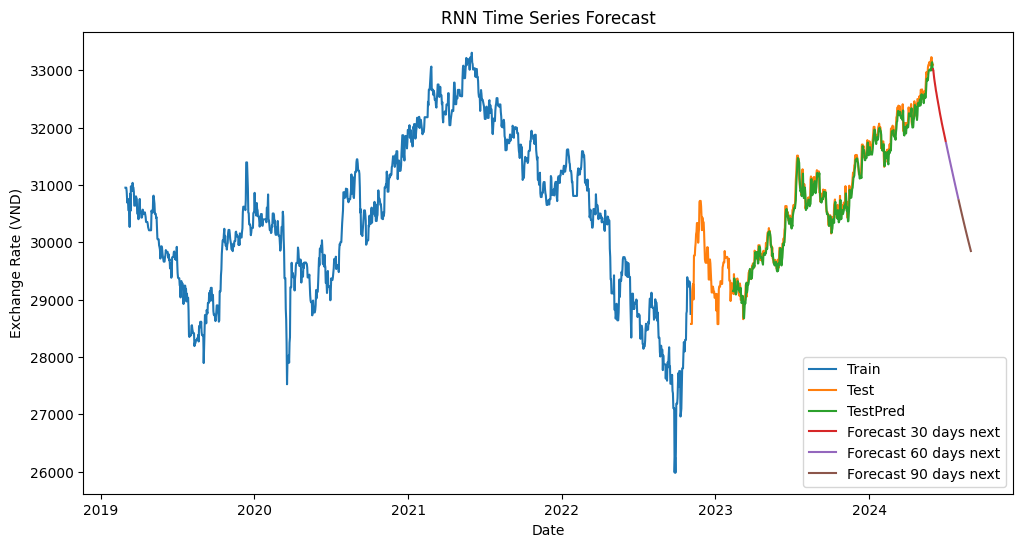

RMSE = 129.92077344234673
MAPE(%) = 0.3272194039393352
MAE = 101.47572544642857


In [16]:
implement_RNN(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3788 - val_loss: 0.0062
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - val_loss: 0.0040
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 8.1502e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 9.1980e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 7.2002e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 9.2907e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 8.1665e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 7.5203e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 6.5542e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8082e-04 - val_loss: 3.7398e-04
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8236e-04 - val_loss: 3.8416e-04
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4404e-04 - val_loss: 3.7269e-04
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0228e-04 - val_loss: 3.8732e-04
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9521e-04 - val_loss: 3.9807e-04
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2308e-04 - val_loss: 5.1163e-04
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6757e-04 - val_loss: 3.6868e-04
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1941e-04 - val_loss: 4.3284e-04
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1885e-04 - val_loss: 4.0510e-04
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7280e-04 - val_loss: 3.5984e-04
Epoch 76/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2864e-04

4 day output [[0.9198043]]
5 day input [0.8030303  0.81572482 0.8030303  0.8030303  0.8030303  0.82391482
 0.82760033 0.84657385 0.84862135 0.86936937 0.86936937 0.86936937
 0.87401037 0.85681136 0.86527437 0.87278187 0.85544636 0.85544636
 0.85544636 0.85517336 0.84220584 0.85394485 0.87728638 0.81381381
 0.81381381 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782
 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 

12 day output [[0.85047275]]
13 day input [0.84862135 0.86936937 0.86936937 0.86936937 0.87401037 0.85681136
 0.86527437 0.87278187 0.85544636 0.85544636 0.85544636 0.85517336
 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.971471

22 day output [[0.77425855]]
23 day input [0.85544636 0.85517336 0.84220584 0.85394485 0.87728638 0.81381381
 0.81381381 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782
 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.95236957
 0.95122415 0.93740767 0.93136364 0.91980428 0.91058481 0.90034777
 0.89052719 0.884813

32 day output [[0.70455784]]
33 day input [0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.95236957 0.95122415 0.93740767 0.93136364 0.91980428
 0.91058481 0.90034777 0.89052719 0.88481355 0.87551463 0.86702371
 0.85771501 0.85047275 0.84211785 0.836429   0.82735801 0.81976408
 0.81125474 0.8040386

42 day output [[0.63863134]]
43 day input [0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.95236957 0.95122415 0.93740767
 0.93136364 0.91980428 0.91058481 0.90034777 0.89052719 0.88481355
 0.87551463 0.86702371 0.85771501 0.85047275 0.84211785 0.836429
 0.82735801 0.81976408 0.81125474 0.80403864 0.7965191  0.78946114
 0.78233027 0.77425855 0.7673102  0.75978166 0.75334758 0.74600232
 0.73908532 0.73161817

52 day output [[0.5750387]]
53 day input [0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.95236957
 0.95122415 0.93740767 0.93136364 0.91980428 0.91058481 0.90034777
 0.89052719 0.88481355 0.87551463 0.86702371 0.85771501 0.85047275
 0.84211785 0.836429   0.82735801 0.81976408 0.81125474 0.80403864
 0.7965191  0.78946114 0.78233027 0.77425855 0.7673102  0.75978166
 0.75334758 0.74600232 0.73908532 0.73161817 0.72454798 0.717673
 0.71098518 0.70455784 0.69763368 0.6908226  0.68374032 0.6773023
 0.67074364 0.66476816 0

62 day output [[0.5135955]]
63 day input [0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.95236957 0.95122415 0.93740767 0.93136364 0.91980428
 0.91058481 0.90034777 0.89052719 0.88481355 0.87551463 0.86702371
 0.85771501 0.85047275 0.84211785 0.836429   0.82735801 0.81976408
 0.81125474 0.80403864 0.7965191  0.78946114 0.78233027 0.77425855
 0.7673102  0.75978166 0.75334758 0.74600232 0.73908532 0.73161817
 0.72454798 0.717673   0.71098518 0.70455784 0.69763368 0.6908226
 0.68374032 0.6773023  0.67074364 0.66476816 0.65818095 0.65186924
 0.64491093 0.63863134 0.63219523 0.62590724 0.61951852 0.61314672
 0.60679018 0.60025167 

72 day output [[0.45538843]]
73 day input [0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.95236957 0.95122415 0.93740767
 0.93136364 0.91980428 0.91058481 0.90034777 0.89052719 0.88481355
 0.87551463 0.86702371 0.85771501 0.85047275 0.84211785 0.836429
 0.82735801 0.81976408 0.81125474 0.80403864 0.7965191  0.78946114
 0.78233027 0.77425855 0.7673102  0.75978166 0.75334758 0.74600232
 0.73908532 0.73161817 0.72454798 0.717673   0.71098518 0.70455784
 0.69763368 0.6908226  0.68374032 0.6773023  0.67074364 0.66476816
 0.65818095 0.65186924 0.64491093 0.63863134 0.63219523 0.62590724
 0.61951852 0.61314672 0.60679018 0.60025167 0.59405905 0.58764648
 0.58147591 0.57503867 0.56878114 0.56239611 0.55622458 0.54997545
 0.54381269 0.53768891

82 day output [[0.39992854]]
83 day input [0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.95236957
 0.95122415 0.93740767 0.93136364 0.91980428 0.91058481 0.90034777
 0.89052719 0.88481355 0.87551463 0.86702371 0.85771501 0.85047275
 0.84211785 0.836429   0.82735801 0.81976408 0.81125474 0.80403864
 0.7965191  0.78946114 0.78233027 0.77425855 0.7673102  0.75978166
 0.75334758 0.74600232 0.73908532 0.73161817 0.72454798 0.717673
 0.71098518 0.70455784 0.69763368 0.6908226  0.68374032 0.6773023
 0.67074364 0.66476816 0.65818095 0.65186924 0.64491093 0.63863134
 0.63219523 0.62590724 0.61951852 0.61314672 0.60679018 0.60025167
 0.59405905 0.58764648 0.58147591 0.57503867 0.56878114 0.56239611
 0.55622458 0.54997545 0.54381269 0.53768891 0.5315401  0.52550513
 0.51947516 0.51359552 0.50758868 0.50175387 0.49583706 0.49005044
 0.48423639 0.47849536 

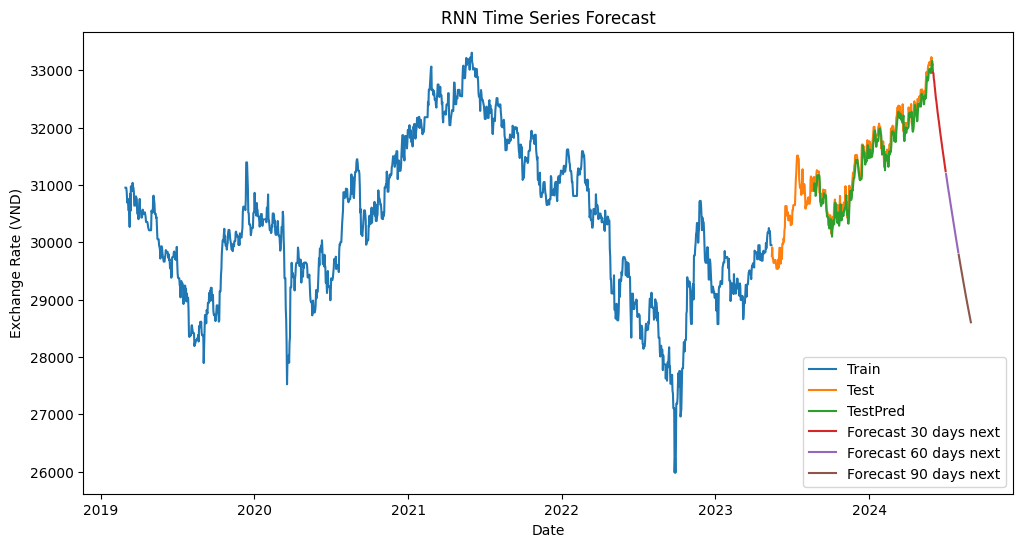

RMSE = 162.95583111648273
MAPE(%) = 0.42469813364096004
MAE = 134.22760095730638


In [17]:
implement_RNN(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1136 - val_loss: 0.0212
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.3674e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.5139e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 6.8587e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 7.7617e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9291e-04 - val_loss: 2.2366e-04
Epoch 66/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0721e-04 - val_loss: 2.2158e-04
Epoch 67/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9963e-04 - val_loss: 2.3022e-04
Epoch 68/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1695e-04 - val_loss: 3.2862e-04
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2645e-04 - val_loss: 7.0336e-04
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0693e-04 - val_loss: 2.2639e-04
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9405e-04 - val_loss: 3.1085e-04
Epoch 72/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7936e-04 - val_loss: 2.6222e-04
Epoch 73/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7681e-04 - val_loss: 3.0123e-04
Epoch 74/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5563e-04 - val_loss: 2.6761e-04
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9232e-04 

4 day output [[0.9069844]]
5 day input [0.8030303  0.81572482 0.8030303  0.8030303  0.8030303  0.82391482
 0.82760033 0.84657385 0.84862135 0.86936937 0.86936937 0.86936937
 0.87401037 0.85681136 0.86527437 0.87278187 0.85544636 0.85544636
 0.85544636 0.85517336 0.84220584 0.85394485 0.87728638 0.81381381
 0.81381381 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782
 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 

14 day output [[0.8081363]]
15 day input [0.86936937 0.86936937 0.87401037 0.85681136 0.86527437 0.87278187
 0.85544636 0.85544636 0.85544636 0.85517336 0.84220584 0.85394485
 0.87728638 0.81381381 0.81381381 0.81381381 0.81599782 0.83292383
 0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.95544493

24 day output [[0.72226447]]
25 day input [0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.95544493 0.9455483  0.93101501
 0.91777575 0.90698439 0.89674538 0.88484293 0.87416142 0.86486065
 0.85458225 0.843680

32 day output [[0.65378743]]
33 day input [0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.95544493 0.9455483  0.93101501 0.91777575 0.90698439
 0.89674538 0.88484293 0.87416142 0.86486065 0.85458225 0.84368032
 0.83503109 0.8268826  0.81762344 0.80813628 0.79844707 0.79014784
 0.78195882 0.7731124

40 day output [[0.57945853]]
41 day input [0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.95544493
 0.9455483  0.93101501 0.91777575 0.90698439 0.89674538 0.88484293
 0.87416142 0.86486065 0.85458225 0.84368032 0.83503109 0.8268826
 0.81762344 0.80813628 0.79844707 0.79014784 0.78195882 0.77311248
 0.76459098 0.75622767 0.74769717 0.73941147 0.73089701 0.72226447
 0.71392876 0.7054409

49 day output [[0.49078625]]
50 day input [0.82896533 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088
 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637
 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.95544493 0.9455483  0.93101501 0.91777575
 0.90698439 0.89674538 0.88484293 0.87416142 0.86486065 0.85458225
 0.84368032 0.83503109 0.8268826  0.81762344 0.80813628 0.79844707
 0.79014784 0.78195882 0.77311248 0.76459098 0.75622767 0.74769717
 0.73941147 0.73089701 0.72226447 0.71392876 0.70544094 0.69708496
 0.68863517 0.68013328 0.67158663 0.66275591 0.65378743 0.64482284
 0.63574749 0.6265316

57 day output [[0.4114411]]
58 day input [0.87769588 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589
 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044
 0.91195741 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239
 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641
 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.95544493 0.9455483  0.93101501 0.91777575 0.90698439 0.89674538
 0.88484293 0.87416142 0.86486065 0.85458225 0.84368032 0.83503109
 0.8268826  0.81762344 0.80813628 0.79844707 0.79014784 0.78195882
 0.77311248 0.76459098 0.75622767 0.74769717 0.73941147 0.73089701
 0.72226447 0.71392876 0.70544094 0.69708496 0.68863517 0.68013328
 0.67158663 0.66275591 0.65378743 0.64482284 0.63574749 0.62653166
 0.61727268 0.60790592 0.59854019 0.58905214 0.57945853 0.5698269
 0.5601567  0.55046141 

67 day output [[0.3172781]]
68 day input [0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.95544493 0.9455483  0.93101501 0.91777575
 0.90698439 0.89674538 0.88484293 0.87416142 0.86486065 0.85458225
 0.84368032 0.83503109 0.8268826  0.81762344 0.80813628 0.79844707
 0.79014784 0.78195882 0.77311248 0.76459098 0.75622767 0.74769717
 0.73941147 0.73089701 0.72226447 0.71392876 0.70544094 0.69708496
 0.68863517 0.68013328 0.67158663 0.66275591 0.65378743 0.64482284
 0.63574749 0.62653166 0.61727268 0.60790592 0.59854019 0.58905214
 0.57945853 0.5698269  0.5601567  0.55046141 0.54069203 0.53073919
 0.5207082  0.51080853 0.50086033 0.49078625 0.48073435 0.4707813
 0.4608745  0.45099676

76 day output [[0.24390727]]
77 day input [0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.95544493
 0.9455483  0.93101501 0.91777575 0.90698439 0.89674538 0.88484293
 0.87416142 0.86486065 0.85458225 0.84368032 0.83503109 0.8268826
 0.81762344 0.80813628 0.79844707 0.79014784 0.78195882 0.77311248
 0.76459098 0.75622767 0.74769717 0.73941147 0.73089701 0.72226447
 0.71392876 0.70544094 0.69708496 0.68863517 0.68013328 0.67158663
 0.66275591 0.65378743 0.64482284 0.63574749 0.62653166 0.61727268
 0.60790592 0.59854019 0.58905214 0.57945853 0.5698269  0.5601567
 0.55046141 0.54069203 0.53073919 0.5207082  0.51080853 0.50086033
 0.49078625 0.48073435 0.4707813  0.4608745  0.45099676 0.44109961
 0.43114865 0.42123869 0.41144109 0.4017069  0.3919633  0.38228455
 0.37269667 0.36320779

84 day output [[0.19235635]]
85 day input [0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.95544493 0.9455483  0.93101501
 0.91777575 0.90698439 0.89674538 0.88484293 0.87416142 0.86486065
 0.85458225 0.84368032 0.83503109 0.8268826  0.81762344 0.80813628
 0.79844707 0.79014784 0.78195882 0.77311248 0.76459098 0.75622767
 0.74769717 0.73941147 0.73089701 0.72226447 0.71392876 0.70544094
 0.69708496 0.68863517 0.68013328 0.67158663 0.66275591 0.65378743
 0.64482284 0.63574749 0.62653166 0.61727268 0.60790592 0.59854019
 0.58905214 0.57945853 0.5698269  0.5601567  0.55046141 0.54069203
 0.53073919 0.5207082  0.51080853 0.50086033 0.49078625 0.48073435
 0.4707813  0.4608745  0.45099676 0.44109961 0.43114865 0.42123869
 0.41144109 0.4017069  0.3919633  0.38228455 0.37269667 0.36320779
 0.35384381 0.34456408 0.3353323  0.32621858 0.31727809 0.30848771
 0.29983258 0.291300

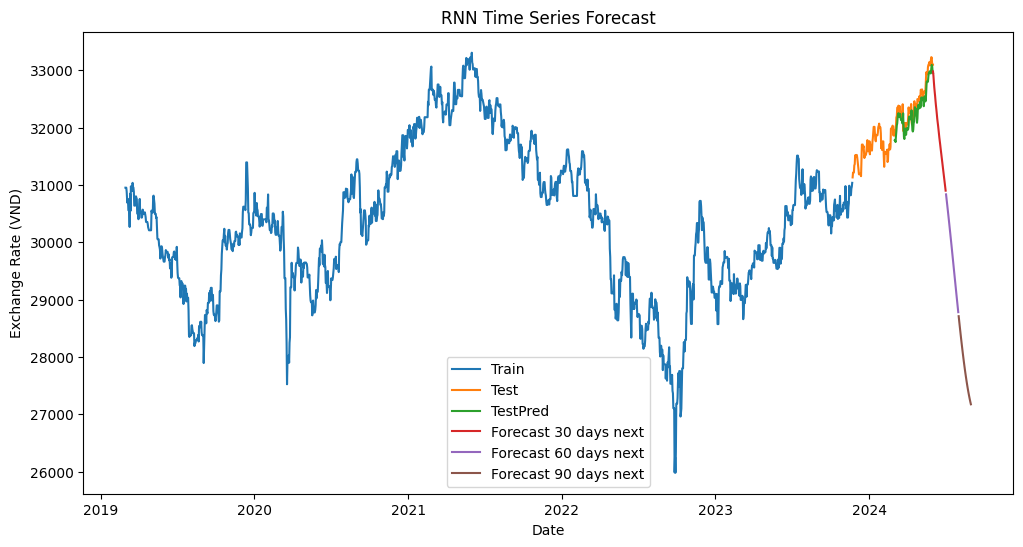

RMSE = 167.6087088888108
MAPE(%) = 0.45232172189161657
MAE = 146.88147503396775


In [18]:
implement_RNN(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND

In [19]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
 ## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
 ## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1019 - val_loss: 0.0045
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7312e-04 - val_loss: 0.0013
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6438e-04 - val_loss: 0.0012
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0663e-04 - val_loss: 0.0011
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1726e-04 - val_loss: 0.0010
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6735e-04 - val_loss: 9.7718e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6904e-04 - val_loss: 9.8845e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7575e-04 - val_loss: 8.6000e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8652e-04 - val_loss: 8.4397e-04
Epoch 12/100
20/20

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7392e-04 - val_loss: 2.8301e-04
Epoch 66/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3238e-04 - val_loss: 2.9376e-04
Epoch 67/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6530e-04 - val_loss: 3.0759e-04
Epoch 68/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6410e-04 - val_loss: 2.7488e-04
Epoch 69/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5371e-04 - val_loss: 2.7567e-04
Epoch 70/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0721e-04 - val_loss: 2.8696e-04
Epoch 71/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4232e-04 - val_loss: 2.8669e-04
Epoch 72/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2085e-04 - val_loss: 3.3314e-04
Epoch 73/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3511e-04 - val_loss: 2.7706e-04
Epoch 74/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8135e-04 - val_loss: 3.0532e-04
Epoch 75/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4013e-0

4 day output [[0.03839885]]
5 day input [0.04580397 0.06534273 0.04868674 0.04868674 0.04868674 0.05893658
 0.05893658 0.07110826 0.10313901 0.10185778 0.10185778 0.10185778
 0.12139654 0.10938501 0.10345932 0.10474055 0.0941704  0.0941704
 0.0941704  0.08392056 0.06646381 0.05188981 0.05813581 0.05028828
 0.05028828 0.05028828 0.04996797 0.05285074 0.05076874 0.05092889
 0.05621397 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457
 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919
 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089
 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519
 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275
 0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  

13 day output [[0.0589824]]
14 day input [0.10185778 0.10185778 0.10185778 0.12139654 0.10938501 0.10345932
 0.10474055 0.0941704  0.0941704  0.0941704  0.08392056 0.06646381
 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828 0.04996797
 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397 0.05621397
 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826 0.07110826
 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274
 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534
 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155
 0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 

23 day output [[0.07675159]]
24 day input [0.08392056 0.06646381 0.05188981 0.05813581 0.05028828 0.05028828
 0.05028828 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397
 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304
 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904
 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966
 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196
 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275
 0.03539398 0.01713645 0.         0.05188981 0.08728379 0.09096733
 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413
 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.0390733  0.0335425
 0.03075731 0.02816913 0.03839885 0.04701495 0.05412703 0.05522654
 0.04780157 0.0528892

33 day output [[0.10620198]]
34 day input [0.05092889 0.05621397 0.05621397 0.05621397 0.05445227 0.06262012
 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919
 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274
 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519
 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275
 0.02370275 0.02370275 0.03539398 0.01713645 0.         0.05188981
 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.0390733  0.0335425  0.03075731 0.02816913 0.03839885 0.04701495
 0.05412703 0.05522654 0.04780157 0.05288922 0.05826872 0.0577881
 0.05757274 0.0589824  0.06257701 0.06896302 0.07417005 0.06976227
 0.07348074 0.0720647

43 day output [[0.12953833]]
44 day input [0.07110826 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274
 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534
 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155
 0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.0390733  0.0335425  0.03075731 0.02816913
 0.03839885 0.04701495 0.05412703 0.05522654 0.04780157 0.05288922
 0.05826872 0.0577881  0.05757274 0.0589824  0.06257701 0.06896302
 0.07417005 0.06976227 0.07348074 0.07206476 0.07504214 0.08012913
 0.07907662 0.07675159 0.07517146 0.07119642 0.07719643 0.07696645
 0.0807253  0.08546537

53 day output [[0.14835462]]
54 day input [0.06518258 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196
 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275
 0.03539398 0.01713645 0.         0.05188981 0.08728379 0.09096733
 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413
 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.0390733  0.0335425
 0.03075731 0.02816913 0.03839885 0.04701495 0.05412703 0.05522654
 0.04780157 0.05288922 0.05826872 0.0577881  0.05757274 0.0589824
 0.06257701 0.06896302 0.07417005 0.06976227 0.07348074 0.07206476
 0.07504214 0.08012913 0.07907662 0.07675159 0.07517146 0.07119642
 0.07719643 0.07696645 0.0807253  0.08546537 0.0891199  0.09778935
 0.10504301 0.10620198 0.10726053 0.10651109 0.10598743 0.11049655
 0.1131621  0.11410138

63 day output [[0.16697302]]
64 day input [0.02370275 0.02370275 0.03539398 0.01713645 0.         0.05188981
 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.0390733  0.0335425  0.03075731 0.02816913 0.03839885 0.04701495
 0.05412703 0.05522654 0.04780157 0.05288922 0.05826872 0.0577881
 0.05757274 0.0589824  0.06257701 0.06896302 0.07417005 0.06976227
 0.07348074 0.07206476 0.07504214 0.08012913 0.07907662 0.07675159
 0.07517146 0.07119642 0.07719643 0.07696645 0.0807253  0.08546537
 0.0891199  0.09778935 0.10504301 0.10620198 0.10726053 0.10651109
 0.10598743 0.11049655 0.1131621  0.11410138 0.11886011 0.12375849
 0.12716815 0.12953833 0.12985402 0.13290703 0.13446745 0.13945554
 0.14480694 0.1442980

73 day output [[0.19220331]]
74 day input [0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.0390733  0.0335425  0.03075731 0.02816913
 0.03839885 0.04701495 0.05412703 0.05522654 0.04780157 0.05288922
 0.05826872 0.0577881  0.05757274 0.0589824  0.06257701 0.06896302
 0.07417005 0.06976227 0.07348074 0.07206476 0.07504214 0.08012913
 0.07907662 0.07675159 0.07517146 0.07119642 0.07719643 0.07696645
 0.0807253  0.08546537 0.0891199  0.09778935 0.10504301 0.10620198
 0.10726053 0.10651109 0.10598743 0.11049655 0.1131621  0.11410138
 0.11886011 0.12375849 0.12716815 0.12953833 0.12985402 0.13290703
 0.13446745 0.13945554 0.14480694 0.14429809 0.14107537 0.14380153
 0.14761399 0.14835462 0.14939564 0.15260786 0.15487568 0.16111369
 0.16507393 0.1663671

83 day output [[0.21377778]]
84 day input [0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.0390733  0.0335425
 0.03075731 0.02816913 0.03839885 0.04701495 0.05412703 0.05522654
 0.04780157 0.05288922 0.05826872 0.0577881  0.05757274 0.0589824
 0.06257701 0.06896302 0.07417005 0.06976227 0.07348074 0.07206476
 0.07504214 0.08012913 0.07907662 0.07675159 0.07517146 0.07119642
 0.07719643 0.07696645 0.0807253  0.08546537 0.0891199  0.09778935
 0.10504301 0.10620198 0.10726053 0.10651109 0.10598743 0.11049655
 0.1131621  0.11410138 0.11886011 0.12375849 0.12716815 0.12953833
 0.12985402 0.13290703 0.13446745 0.13945554 0.14480694 0.14429809
 0.14107537 0.14380153 0.14761399 0.14835462 0.14939564 0.15260786
 0.15487568 0.16111369 0.16507393 0.16636716 0.1639536  0.1613258
 0.16470335 0.16697302 0.16967362 0.17577371 0.18030289 0.18511856
 0.18839517 0.18953755 

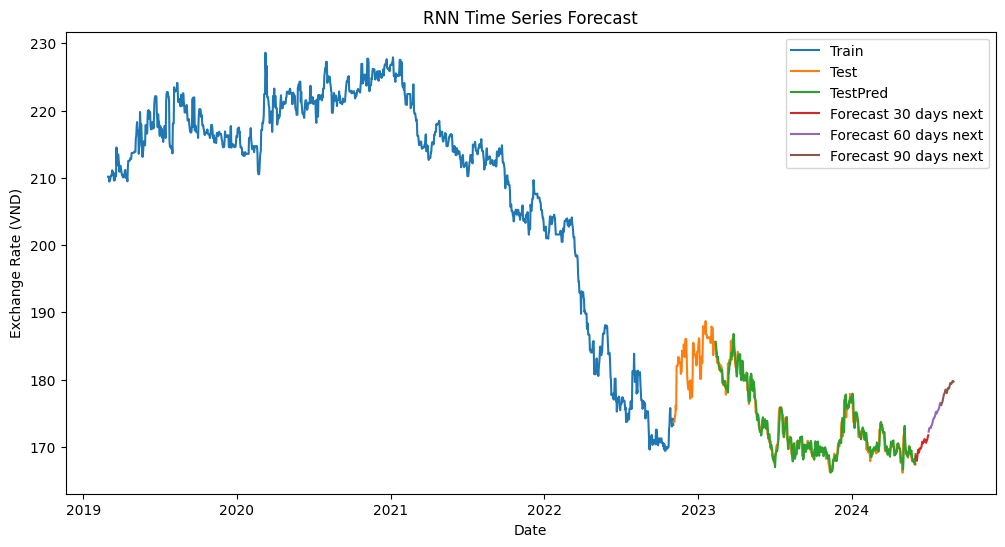

RMSE = 1.0035818916529373
MAPE(%) = 0.4255681393539957
MAE = 0.7382645179043295


In [20]:
implement_RNN(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2747 - val_loss: 0.0457
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val

Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1422e-04 - val_loss: 2.2351e-04
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7492e-04 - val_loss: 2.2350e-04
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9911e-04 - val_loss: 4.1873e-04
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7774e-04 - val_loss: 2.6091e-04
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5293e-04 - val_loss: 4.6786e-04
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7667e-04 - val_loss: 3.0895e-04
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7630e-04 - val_loss: 2.7769e-04
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8472e-04 - val_loss: 2.3127e-04
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3333e-04 - val_loss: 2.4372e-04
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6233e-04 - val_loss: 4.2560e-04
Epoch 76/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

4 day output [[0.08760206]]
5 day input [0.04580397 0.06534273 0.04868674 0.04868674 0.04868674 0.05893658
 0.05893658 0.07110826 0.10313901 0.10185778 0.10185778 0.10185778
 0.12139654 0.10938501 0.10345932 0.10474055 0.0941704  0.0941704
 0.0941704  0.08392056 0.06646381 0.05188981 0.05813581 0.05028828
 0.05028828 0.05028828 0.04996797 0.05285074 0.05076874 0.05092889
 0.05621397 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457
 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919
 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089
 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519
 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275
 0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  

13 day output [[0.17873383]]
14 day input [0.10185778 0.10185778 0.10185778 0.12139654 0.10938501 0.10345932
 0.10474055 0.0941704  0.0941704  0.0941704  0.08392056 0.06646381
 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828 0.04996797
 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397 0.05621397
 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826 0.07110826
 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274
 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534
 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155
 0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937

21 day output [[0.27370396]]
22 day input [0.0941704  0.0941704  0.08392056 0.06646381 0.05188981 0.05813581
 0.05028828 0.05028828 0.05028828 0.04996797 0.05285074 0.05076874
 0.05092889 0.05621397 0.05621397 0.05621397 0.05445227 0.06262012
 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919
 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274
 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519
 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275
 0.02370275 0.02370275 0.03539398 0.01713645 0.         0.05188981
 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.04428885 0.05554775 0.06538393 0.08042207 0.08760206 0.09994052
 0.1084291  0.115668

29 day output [[0.34738004]]
30 day input [0.05028828 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397
 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304
 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904
 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966
 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196
 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275
 0.03539398 0.01713645 0.         0.05188981 0.08728379 0.09096733
 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413
 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.04428885 0.05554775
 0.06538393 0.08042207 0.08760206 0.09994052 0.1084291  0.11566861
 0.12659708 0.13739474 0.14882767 0.16056579 0.16852728 0.17873383
 0.1929573  0.203967

39 day output [[0.41098565]]
40 day input [0.06726457 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919
 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274
 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519
 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275
 0.02370275 0.02370275 0.03539398 0.01713645 0.         0.05188981
 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.04428885 0.05554775 0.06538393 0.08042207 0.08760206 0.09994052
 0.1084291  0.11566861 0.12659708 0.13739474 0.14882767 0.16056579
 0.16852728 0.17873383 0.1929573  0.20396784 0.21617831 0.23018296
 0.24262695 0.25186577 0.26426658 0.27370396 0.28410462 0.29785708
 0.30693519 0.317968

49 day output [[0.45313975]]
50 day input [0.04452274 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534
 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155
 0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.04428885 0.05554775 0.06538393 0.08042207
 0.08760206 0.09994052 0.1084291  0.11566861 0.12659708 0.13739474
 0.14882767 0.16056579 0.16852728 0.17873383 0.1929573  0.20396784
 0.21617831 0.23018296 0.24262695 0.25186577 0.26426658 0.27370396
 0.28410462 0.29785708 0.30693519 0.31796816 0.32640189 0.33261299
 0.34079784 0.34738004 0.35290337 0.36106345 0.36808747 0.37562111
 0.38258138 0.3880243 

59 day output [[0.48839137]]
60 day input [0.06181935 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275
 0.03539398 0.01713645 0.         0.05188981 0.08728379 0.09096733
 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413
 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.04428885 0.05554775
 0.06538393 0.08042207 0.08760206 0.09994052 0.1084291  0.11566861
 0.12659708 0.13739474 0.14882767 0.16056579 0.16852728 0.17873383
 0.1929573  0.20396784 0.21617831 0.23018296 0.24262695 0.25186577
 0.26426658 0.27370396 0.28410462 0.29785708 0.30693519 0.31796816
 0.32640189 0.33261299 0.34079784 0.34738004 0.35290337 0.36106345
 0.36808747 0.37562111 0.38258138 0.3880243  0.39459965 0.40015605
 0.40597707 0.41098565 0.41614166 0.42121017 0.42556646 0.4302668
 0.43374524 0.4379915

69 day output [[0.5221921]]
70 day input [0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.04428885 0.05554775 0.06538393 0.08042207 0.08760206 0.09994052
 0.1084291  0.11566861 0.12659708 0.13739474 0.14882767 0.16056579
 0.16852728 0.17873383 0.1929573  0.20396784 0.21617831 0.23018296
 0.24262695 0.25186577 0.26426658 0.27370396 0.28410462 0.29785708
 0.30693519 0.31796816 0.32640189 0.33261299 0.34079784 0.34738004
 0.35290337 0.36106345 0.36808747 0.37562111 0.38258138 0.3880243
 0.39459965 0.40015605 0.40597707 0.41098565 0.41614166 0.42121017
 0.42556646 0.4302668  0.43374524 0.43799153 0.44239143 0.44591567
 0.44983813 0.45313975 0.45615259 0.46025285 0.46316671 0.46669343
 0.47066206 0.47405896

79 day output [[0.5568008]]
80 day input [0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.04428885 0.05554775 0.06538393 0.08042207
 0.08760206 0.09994052 0.1084291  0.11566861 0.12659708 0.13739474
 0.14882767 0.16056579 0.16852728 0.17873383 0.1929573  0.20396784
 0.21617831 0.23018296 0.24262695 0.25186577 0.26426658 0.27370396
 0.28410462 0.29785708 0.30693519 0.31796816 0.32640189 0.33261299
 0.34079784 0.34738004 0.35290337 0.36106345 0.36808747 0.37562111
 0.38258138 0.3880243  0.39459965 0.40015605 0.40597707 0.41098565
 0.41614166 0.42121017 0.42556646 0.4302668  0.43374524 0.43799153
 0.44239143 0.44591567 0.44983813 0.45313975 0.45615259 0.46025285
 0.46316671 0.46669343 0.47066206 0.47405896 0.47820181 0.48148748
 0.48486975 0.48839137 0.49159062 0.49512544 0.49834141 0.50172597
 0.50523645 0.50849634

89 day output [[0.59335047]]
90 day input [0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.04428885 0.05554775
 0.06538393 0.08042207 0.08760206 0.09994052 0.1084291  0.11566861
 0.12659708 0.13739474 0.14882767 0.16056579 0.16852728 0.17873383
 0.1929573  0.20396784 0.21617831 0.23018296 0.24262695 0.25186577
 0.26426658 0.27370396 0.28410462 0.29785708 0.30693519 0.31796816
 0.32640189 0.33261299 0.34079784 0.34738004 0.35290337 0.36106345
 0.36808747 0.37562111 0.38258138 0.3880243  0.39459965 0.40015605
 0.40597707 0.41098565 0.41614166 0.42121017 0.42556646 0.4302668
 0.43374524 0.43799153 0.44239143 0.44591567 0.44983813 0.45313975
 0.45615259 0.46025285 0.46316671 0.46669343 0.47066206 0.47405896
 0.47820181 0.48148748 0.48486975 0.48839137 0.49159062 0.49512544
 0.49834141 0.50172597 0.50523645 0.50849634 0.51202434 0.51526231
 0.51859677 0.52219212 0.52530062 0.52883202 0.53219861 0.53559053
 0.53923494 0.5424673

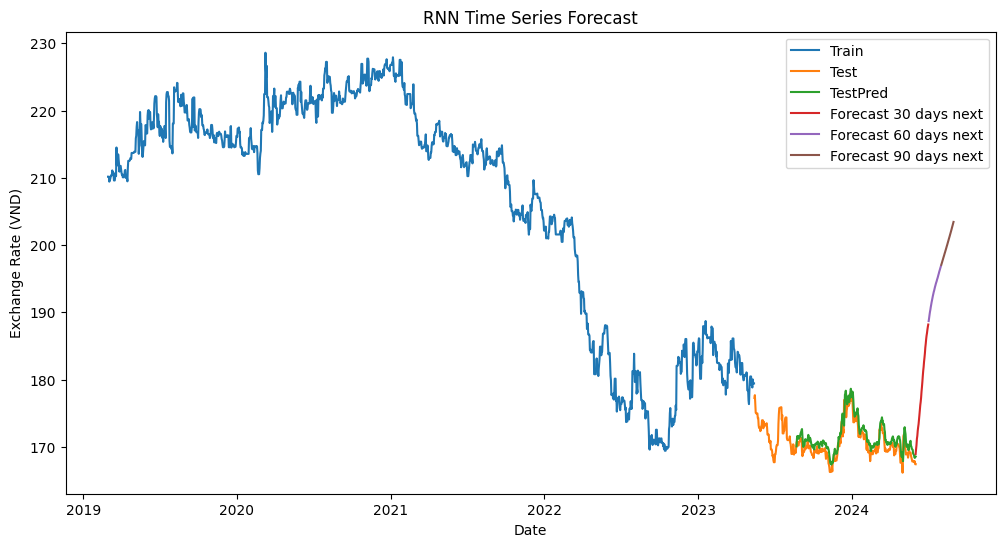

RMSE = 1.3356677286457008
MAPE(%) = 0.6836698750024791
MAE = 1.1639645256794673


In [21]:
implement_RNN(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3442 - val_loss: 0.0018
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - val_loss: 0.0012
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 8.9079e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 6.6334e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0194e-04 - val_loss: 6.0597e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7543e-04 - val_loss: 5.5496e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8195e-04 - val_loss: 5.3015e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8263e-04 - val_loss: 4.9670e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4585e-04 - val_loss: 4.8505e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7094e-04 - val_loss: 4.5275e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9417e-04 - val_loss: 4.5725e-04
Epoch 12/1

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6286e-04 - val_loss: 3.3328e-04
Epoch 66/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5365e-04 - val_loss: 2.3080e-04
Epoch 67/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5606e-04 - val_loss: 2.1749e-04
Epoch 68/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6428e-04 - val_loss: 2.4438e-04
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4084e-04 - val_loss: 2.1259e-04
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5405e-04 - val_loss: 2.1563e-04
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5440e-04 - val_loss: 3.8160e-04
Epoch 72/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8952e-04 - val_loss: 2.1206e-04
Epoch 73/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2924e-04 - val_loss: 2.9230e-04
Epoch 74/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5042e-04 - val_loss: 2.2473e-04
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2217e-04 - 

4 day output [[0.0554653]]
5 day input [0.04580397 0.06534273 0.04868674 0.04868674 0.04868674 0.05893658
 0.05893658 0.07110826 0.10313901 0.10185778 0.10185778 0.10185778
 0.12139654 0.10938501 0.10345932 0.10474055 0.0941704  0.0941704
 0.0941704  0.08392056 0.06646381 0.05188981 0.05813581 0.05028828
 0.05028828 0.05028828 0.04996797 0.05285074 0.05076874 0.05092889
 0.05621397 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457
 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919
 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089
 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519
 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275
 0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0

14 day output [[0.09599075]]
15 day input [0.10185778 0.10185778 0.12139654 0.10938501 0.10345932 0.10474055
 0.0941704  0.0941704  0.0941704  0.08392056 0.06646381 0.05188981
 0.05813581 0.05028828 0.05028828 0.05028828 0.04996797 0.05285074
 0.05076874 0.05092889 0.05621397 0.05621397 0.05621397 0.05445227
 0.06262012 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826
 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274
 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519
 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813
 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02581898 0.0350

24 day output [[0.1480885]]
25 day input [0.06646381 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828
 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397
 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826
 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951
 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258
 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.02581898 0.03508749 0.04202608
 0.04977412 0.0554653  0.06107814 0.06556488 0.06868786 0.06924953
 0.07664353 0.07948442 

34 day output [[0.18551113]]
35 day input [0.05621397 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457
 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919
 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089
 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519
 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275
 0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.02581898
 0.03508749 0.04202608 0.04977412 0.0554653  0.06107814 0.06556488
 0.06868786 0.06924953 0.07664353 0.07948442 0.07956352 0.08123728
 0.08734877 0.09599075 0.10245992 0.10788917 0.11160306 0.11466986
 0.12049945 0.125269

44 day output [[0.2093641]]
45 day input [0.06165919 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274
 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519
 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813
 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02581898 0.03508749 0.04202608 0.04977412 0.0554653
 0.06107814 0.06556488 0.06868786 0.06924953 0.07664353 0.07948442
 0.07956352 0.08123728 0.08734877 0.09599075 0.10245992 0.10788917
 0.11160306 0.11466986 0.12049945 0.12526923 0.12978972 0.13470586
 0.14104342 0.1480885  0.14876406 0.15102458 0.15463376 0.15701981
 0.16209245 0.1655689  0.172258

54 day output [[0.23300816]]
55 day input [0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.02581898 0.03508749 0.04202608
 0.04977412 0.0554653  0.06107814 0.06556488 0.06868786 0.06924953
 0.07664353 0.07948442 0.07956352 0.08123728 0.08734877 0.09599075
 0.10245992 0.10788917 0.11160306 0.11466986 0.12049945 0.12526923
 0.12978972 0.13470586 0.14104342 0.1480885  0.14876406 0.15102458
 0.15463376 0.15701981 0.16209245 0.1655689  0.17225873 0.17908603
 0.18438925 0.18551113 0.18544421 0.18798271 0.19016126 0.19564633
 0.19884294 0.20356743

64 day output [[0.25121728]]
65 day input [0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.02581898
 0.03508749 0.04202608 0.04977412 0.0554653  0.06107814 0.06556488
 0.06868786 0.06924953 0.07664353 0.07948442 0.07956352 0.08123728
 0.08734877 0.09599075 0.10245992 0.10788917 0.11160306 0.11466986
 0.12049945 0.12526923 0.12978972 0.13470586 0.14104342 0.1480885
 0.14876406 0.15102458 0.15463376 0.15701981 0.16209245 0.1655689
 0.17225873 0.17908603 0.18438925 0.18551113 0.18544421 0.18798271
 0.19016126 0.19564633 0.19884294 0.20356743 0.20703122 0.2074424
 0.20822801 0.2093641  0.21282411 0.21724315 0.21953873 0.22204325
 0.22282003 0.22494687 

73 day output [[0.2612302]]
74 day input [0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.02581898 0.03508749 0.04202608 0.04977412
 0.0554653  0.06107814 0.06556488 0.06868786 0.06924953 0.07664353
 0.07948442 0.07956352 0.08123728 0.08734877 0.09599075 0.10245992
 0.10788917 0.11160306 0.11466986 0.12049945 0.12526923 0.12978972
 0.13470586 0.14104342 0.1480885  0.14876406 0.15102458 0.15463376
 0.15701981 0.16209245 0.1655689  0.17225873 0.17908603 0.18438925
 0.18551113 0.18544421 0.18798271 0.19016126 0.19564633 0.19884294
 0.20356743 0.20703122 0.2074424  0.20822801 0.2093641  0.21282411
 0.21724315 0.21953873 0.22204325 0.22282003 0.22494687 0.22619639
 0.22719033 0.2300075  0.23300816 0.23694856 0.23856376 0.23933193
 0.24022016 0.24054399

83 day output [[0.27332214]]
84 day input [0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.02581898 0.03508749
 0.04202608 0.04977412 0.0554653  0.06107814 0.06556488 0.06868786
 0.06924953 0.07664353 0.07948442 0.07956352 0.08123728 0.08734877
 0.09599075 0.10245992 0.10788917 0.11160306 0.11466986 0.12049945
 0.12526923 0.12978972 0.13470586 0.14104342 0.1480885  0.14876406
 0.15102458 0.15463376 0.15701981 0.16209245 0.1655689  0.17225873
 0.17908603 0.18438925 0.18551113 0.18544421 0.18798271 0.19016126
 0.19564633 0.19884294 0.20356743 0.20703122 0.2074424  0.20822801
 0.2093641  0.21282411 0.21724315 0.21953873 0.22204325 0.22282003
 0.22494687 0.22619639 0.22719033 0.2300075  0.23300816 0.23694856
 0.23856376 0.23933193 0.24022016 0.24054399 0.24187006 0.24259776
 0.24521559 0.24807088 0.25121728 0.25161633 0.25205234 0.25319004
 0.25531504 0.257005

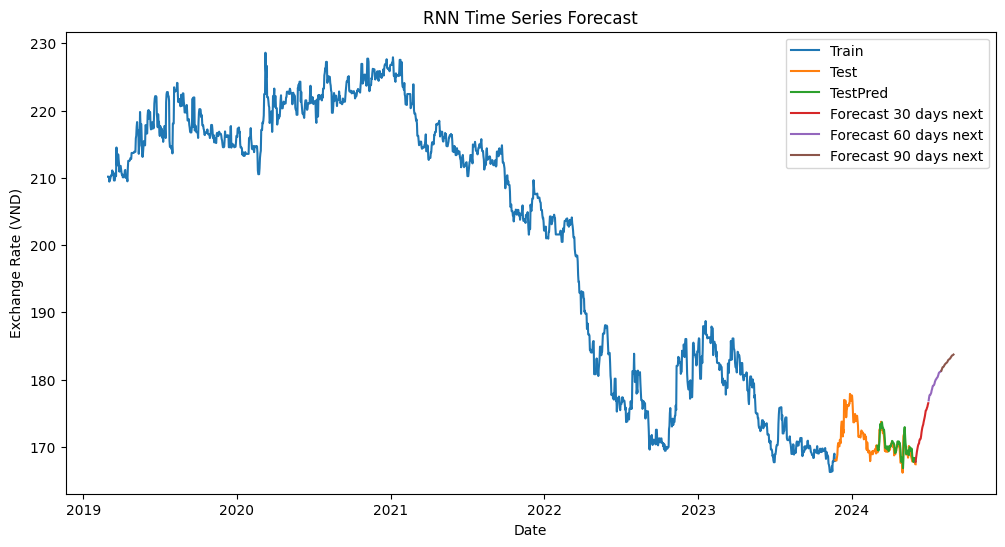

RMSE = 0.9146020230767526
MAPE(%) = 0.4127766226437226
MAE = 0.7005893475076432


In [22]:
implement_RNN(train_jpy_3_sc, test_jpy_3_sc)